In [100]:
# Q.3 Parallel SVD

In [101]:
%matplotlib inline

In [102]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

In [103]:
X = []
y = []
data_admitted = []
data_not_admitted = []
csv_delimiter = ','

def open_file_and_load_data(filename):
    global data_admitted, data_not_admitted, X, y
    fields = ['exam1', 'exam2', 'status']
    df = pandas.read_csv(filename, sep=csv_delimiter, names=fields)
    dataSer = df.values
    for ir in dataSer:
        X.append([ float(ir[0]), float(ir[1]) ])
        y.append([float(ir[2])])
        if (int(ir[2]) == 0):
            data_not_admitted.append(np.array([float(ir[0]),float(ir[1])]))
        else:
            data_admitted.append(np.array([float(ir[0]),float(ir[1])]))
    data_admitted = np.array(data_admitted)
    data_not_admitted = np.array(data_not_admitted)
    X = np.array(X)
    #Note that func should also adds a column of ones for us, so the intercept term is handled
    X = np.insert(X,0,1,axis=1)
    y = np.array(y)

In [104]:
open_file_and_load_data("./ex2-003/mlclass-ex2/ex2data2.txt")
from scipy.special import expit
import random

In [105]:
# Standardize data

In [106]:
from sklearn.preprocessing import PolynomialFeatures

degree = 6

def mapFeature(X1, X2):
    poly = PolynomialFeatures(degree)
    finalX = np.append(X1, X2, 1)
    mapX = poly.fit_transform(finalX)
    print ("Shape of mapped X, ", (mapX.shape))
    return mapX
mapX = mapFeature(X[:,1].reshape(-1,1),X[:,2].reshape(-1,1))

# returns the cost and gradient for logistic regression [J, grad]
def calcCostReg(theta, X, y, lamb):
    #m is the total size of training set
    m = y.size
    # hypothesis function
    h = expit(np.dot(X,theta))
    
    first = np.log(h).T.dot(y)
    second = np.log(1-h).T.dot(1-y)
    
    third =  (lamb/(2*m)) * np.sum(np.square(theta[1:]))
    if (m != 0):
        J = -1*(1/m)*(first + second) + third
        if np.isnan(J[0]):
            return(np.inf)
        return J[0]
    else:
        print ("M is zero.. Cannot calculate J\n")
        return -1

Shape of mapped X,  (118, 28)


In [107]:
import _thread
import datetime
import threading

In [108]:
theta = np.zeros(mapX.shape[1])
J = 0.0
finalJ = []
def parallel_batch_sgd(threadname, X, y, learning_rate, nthreads=1, max_iters=1000, tolerance=1e-3, batch_size=10):
    global theta, J, finalJ
    prevJ = 0.0
    
    for x in range(max_iters):
        r_ind = random.sample(range(len(X)), batch_size)
        X_new = X[r_ind]
        y_new = y[r_ind]
        hypothesis = expit(np.dot(X_new, theta))
        loss = hypothesis - y_new
        gradient = (np.dot(X_new.T, loss))
        theta = theta - learning_rate * gradient * 1/batch_size 
        J = calcCostReg(theta, X, y, 1)
        finalJ.append(J[0])
        print ("%s: %f" % ( threadname, J ))
#         print ("iter %s | J: %.3f" % (x, J))      
        if x == 0:
            prevJ = J
        else:
            if  abs(prevJ - J) < tolerance:
                break
            prevJ = J

        
    return (theta, finalJ, x)

In [109]:
#Repeat steps 2, 3 from Part2 using parallel_batch_sgd().
# Find below graphs and optimization function using parallel_batch_sgd

No-thread: 0.692792
No-thread: 0.692777
Total time taken with normal batch sgd  0:00:00.002112 with LR  0.01
Starting Thread-1
Thread-1: 0.692683
Thread-1: 0.692434
Exiting Thread-1
Starting Thread-2
Thread-2: 0.692343
Thread-2: 0.692168
Exiting Thread-2
Starting Thread-3
Thread-3: 0.692046
Thread-3: 0.691788
Exiting Thread-3
8 8
Total time taken with 3 parallel threads  0:00:00.105936 with LR  0.01
No-thread: 0.692951
No-thread: 0.693178
Total time taken with normal batch sgd  0:00:00.000475 with LR  0.03
Starting Thread-1
Thread-1: 0.692279
Thread-1: 0.691347
Exiting Thread-1
Starting Thread-2
Thread-2: 0.690730
Thread-2: 0.690830
Exiting Thread-2
Starting Thread-3
Thread-3: 0.690227
Thread-3: 0.689796
Exiting Thread-3
16 16
Total time taken with 3 parallel threads  0:00:00.069904 with LR  0.03
No-thread: 0.691330
No-thread: 0.690910
Total time taken with normal batch sgd  0:00:00.000249 with LR  0.05
Starting Thread-1
Thread-1: 0.690767
Thread-1: 0.690216
Exiting Thread-1
Starting T

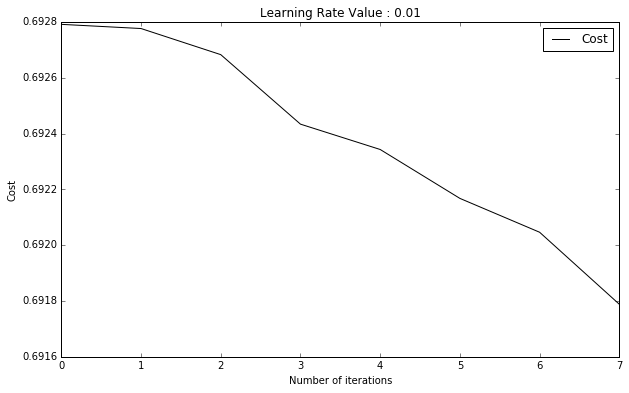

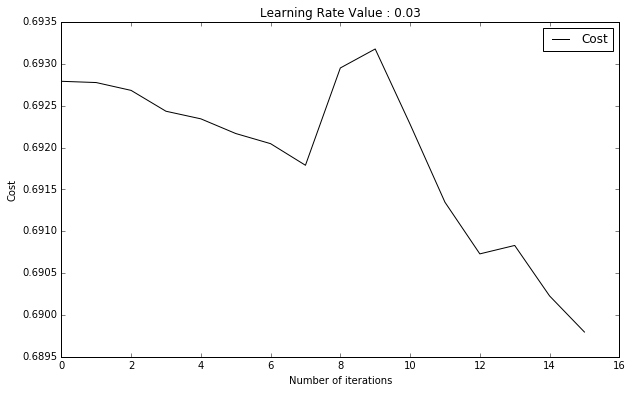

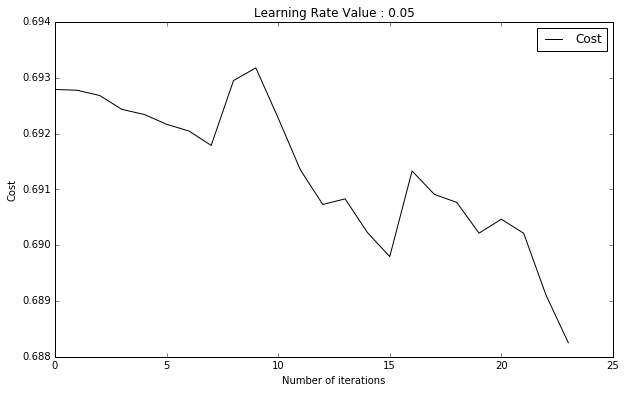

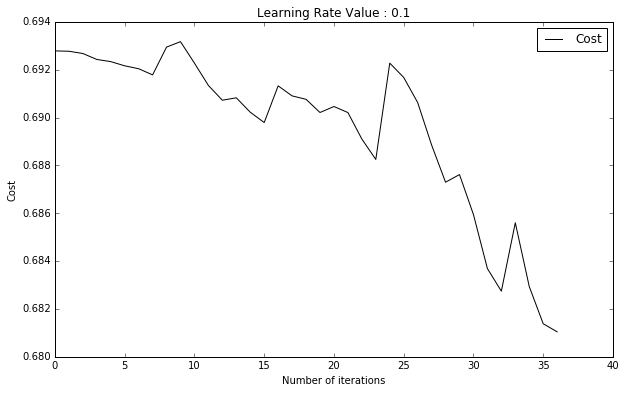

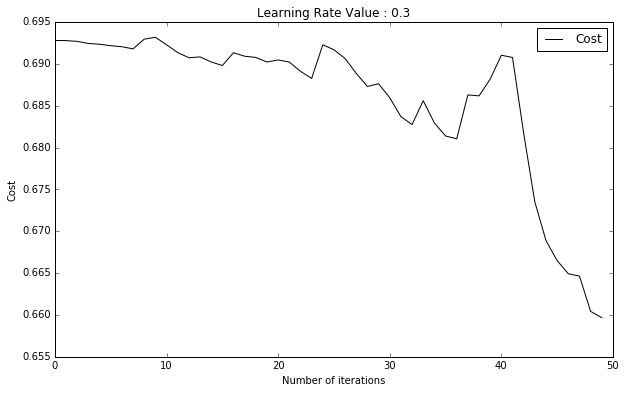

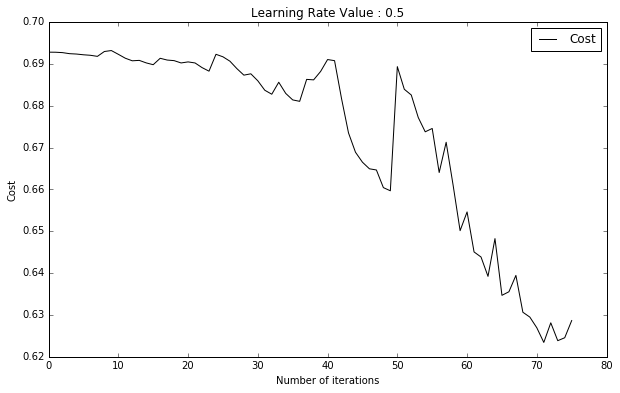

In [110]:
class myThread (threading.Thread):
    def __init__(self, threadID, name, counter, l):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.counter = counter
        self.l = l
        self._return = None
    
    def run(self):
        print ("Starting " + self.name)
        self._return = parallel_batch_sgd(self.name, mapX, y, self.l)
        print ("Exiting " + self.name)
    

def plotGraph(xvals, yvals, l):
    plt.figure(figsize=(10,6))
    plt.plot(xvals, yvals, color= 'black', label='Cost')
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost')
    plt.legend()
    title = 'Learning Rate Value : ' + str(l)
    plt.title(title)

def test_threads():
    global theta
    global finalJ
    global J
    
    lr_values = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]
    for l in lr_values:
        initial_theta = np.zeros(mapX.shape[1])
        theta = initial_theta
        theta = theta.reshape(-1,1)
    
        start_time = datetime.datetime.now()
        parallel_batch_sgd("No-thread", mapX, y, l, 400)
        end_time = datetime.datetime.now()
        time_diff = end_time - start_time
        print ("Total time taken with normal batch sgd ", time_diff, "with LR ", l)
        start_time = datetime.datetime.now()
        thread1 = myThread(1, "Thread-1", 1, l)
        thread2 = myThread(2, "Thread-2", 2, l)
        thread3 = myThread(3, "Thread-3", 3, l)
        thread1.start()
        thread2.start()
        thread3.start()
        thread1.join()
        thread2.join()
        thread3.join()
        
        num_iter = list(range(len(finalJ)))
        cost_iter = finalJ
        print (len(num_iter), len(cost_iter))
        plotGraph(num_iter, cost_iter, l)
        
        end_time = datetime.datetime.now()
        time_diff = end_time - start_time
        print ("Total time taken with 3 parallel threads ", time_diff, "with LR ", l)


    
test_threads()

In [111]:
# Profile the relative speedup of parallel_batch_sgd() for 1,2,3 and 4 threads
# compared to batch_sgd using the same data and parameters (your best learning
# rate, etc.). Does this vary for different learning rates? How sensitive is to
# standardizing the data?

#We see from the timing logs above that the relative performance of the parallel_sgd increases with the increase in 
# in the learning rate (if the number of threads remain constant: 3). Same holds for batch_svd as well


In [112]:
# Observation for different number of threads with same learning rate
# With a constant l = 0.5, varying the number of threads

In [115]:
initial_theta = np.zeros(mapX.shape[1])
theta = initial_theta
theta = theta.reshape(-1,1)
l = 0.5

start_time = datetime.datetime.now()
thread1 = myThread(1, "Thread-1", 1, l)

thread1.start()
thread1.join()

end_time = datetime.datetime.now()
time_diff = end_time - start_time
print ("Total time taken with 1 parallel threads ", time_diff, "with LR ", l)

start_time = datetime.datetime.now()
thread1 = myThread(1, "Thread-1", 1, l)
thread2 = myThread(2, "Thread-2", 2, l)
thread1.start()
thread2.start()
thread1.join()
thread2.join()

end_time = datetime.datetime.now()
time_diff = end_time - start_time
print ("Total time taken with 2 parallel threads ", time_diff, "with LR ", l)

start_time = datetime.datetime.now()
thread1 = myThread(1, "Thread-1", 1, l)
thread2 = myThread(2, "Thread-2", 2, l)
thread3 = myThread(3, "Thread-3", 3, l)
thread1.start()
thread2.start()
thread3.start()
thread1.join()
thread2.join()
thread3.join()

end_time = datetime.datetime.now()
time_diff = end_time - start_time
print ("Total time taken with 3 parallel threads ", time_diff, "with LR ", l)

start_time = datetime.datetime.now()
thread1 = myThread(1, "Thread-1", 1, l)
thread2 = myThread(2, "Thread-2", 2, l)
thread3 = myThread(3, "Thread-3", 3, l)
thread4 = myThread(4, "Thread-4", 4, l)

thread1.start()
thread2.start()
thread3.start()
thread4.start()
thread1.join()
thread2.join()
thread3.join()
thread3.join()

end_time = datetime.datetime.now()
time_diff = end_time - start_time
print ("Total time taken with 4 parallel threads ", time_diff, "with LR ", l)



Starting Thread-1
Thread-1: 0.696800
Thread-1: 0.698670
Thread-1: 0.685961
Thread-1: 0.678852
Thread-1: 0.679130
Exiting Thread-1
Total time taken with 1 parallel threads  0:00:00.002383 with LR  0.5
Starting Thread-1
Thread-1: 0.673589
Thread-1: 0.679626
Thread-1: 0.669233
Thread-1: 0.661013
Thread-1: 0.659937
Thread-1: 0.662926
Starting Thread-2
Thread-2: 0.647924
Thread-2: 0.647908
Exiting Thread-2
Thread-1: 0.653431
Thread-1: 0.643275
Thread-1: 0.639031
Thread-1: 0.637032
Thread-1: 0.636757
Exiting Thread-1
Total time taken with 2 parallel threads  0:00:00.017822 with LR  0.5
Starting Thread-1
Thread-1: 0.632001
Thread-1: 0.627737
Thread-1: 0.624158
Thread-1: 0.620861
Thread-1: 0.619034
Thread-1: 0.617072
Thread-1: 0.614988
Thread-1: 0.612610
Thread-1: 0.612579
Exiting Thread-1
Starting Thread-2
Thread-2: 0.609430
Thread-2: 0.608046
Thread-2: 0.605677
Starting Thread-3
Thread-3: 0.606684
Thread-2: 0.603888
Thread-3: 0.605285
Thread-3: 0.597832
Thread-3: 0.596947
Exiting Thread-3
Th

In [116]:
# Instantiating a single thread generates an extra overhead in itself, with relatively less advantages
# We see that the time definitely reduces with 2 threads, but increases with the thread count 3 and partially 
# decreases again at 4, 
# mostly due to balance betwenn increase in num of workers and thread management and cleanup time.

In [117]:
# Sensitive to standardizing the data:
# If instead of mapped standardized data (mapX) original data was given, the following are the time results:

Starting Thread-1
Thread-1: 0.693172
Thread-1: 0.693134
Exiting Thread-1
Starting Thread-2
Thread-2: 0.693094
Thread-2: 0.693078
Exiting Thread-2
Starting Thread-3
Thread-3: 0.693087
Thread-3: 0.693118
Exiting Thread-3
234 234
Total time taken with 3 parallel threads  0:00:00.082552 with LR  0.01
Starting Thread-1
Thread-1: 0.693188
Thread-1: 0.693195
Exiting Thread-1
Starting Thread-2
Thread-2: 0.693175
Starting Thread-3
Thread-2: 0.693170
Exiting Thread-2
Thread-3: 0.693107
Thread-3: 0.693117
Exiting Thread-3
240 240
Total time taken with 3 parallel threads  0:00:00.066114 with LR  0.03
Starting Thread-1
Starting Thread-2
Thread-2: 0.693128
Thread-1: 0.693224
Thread-1: 0.693097
Exiting Thread-1
Thread-2: 0.693063
Exiting Thread-2
Starting Thread-3
Thread-3: 0.693098
Thread-3: 0.693143
Exiting Thread-3
246 246
Total time taken with 3 parallel threads  0:00:00.041750 with LR  0.05
Starting Thread-1
Thread-1: 0.693231
Thread-1: 0.693038
Exiting Thread-1
Starting Thread-2
Thread-2: 0.692

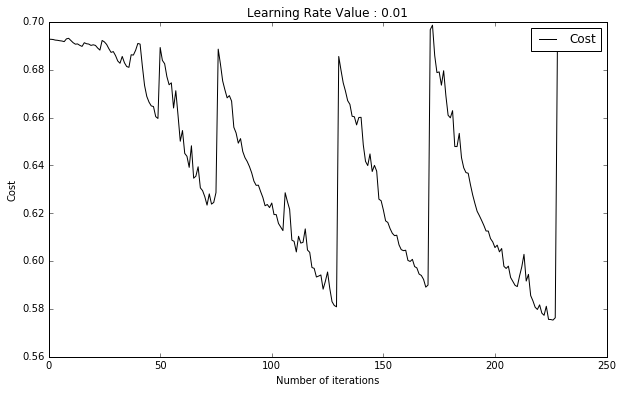

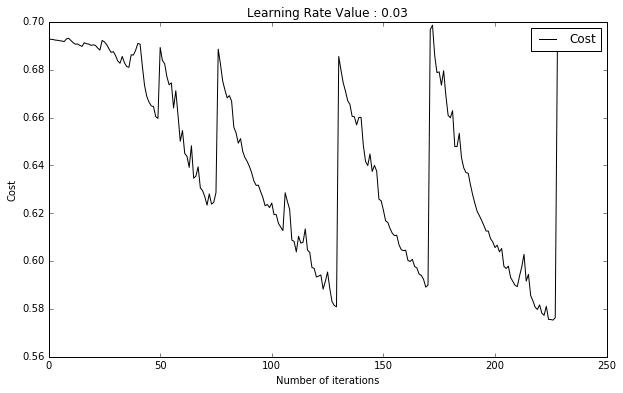

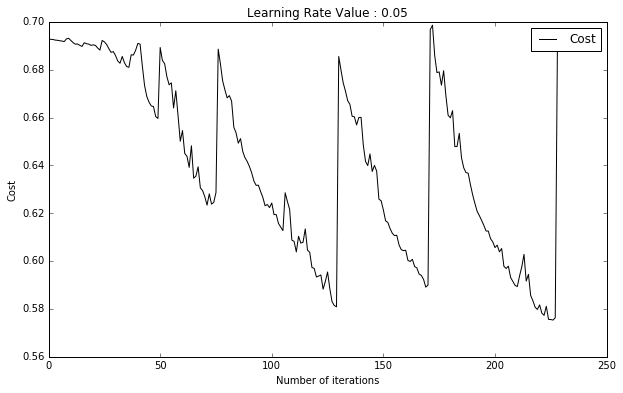

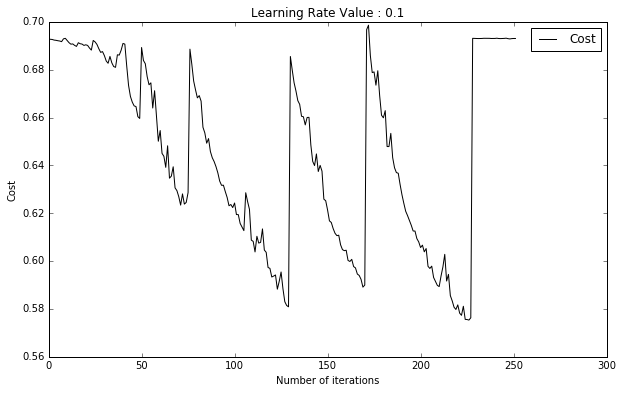

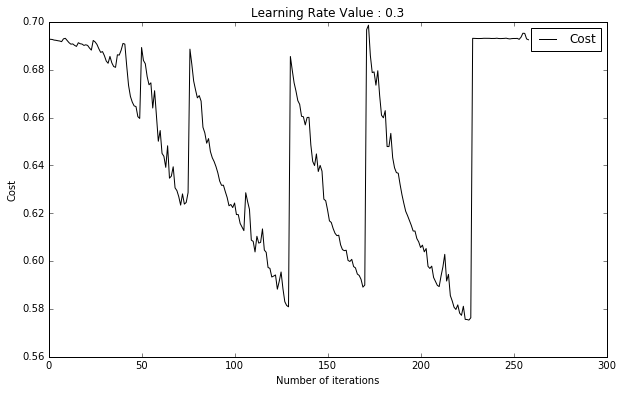

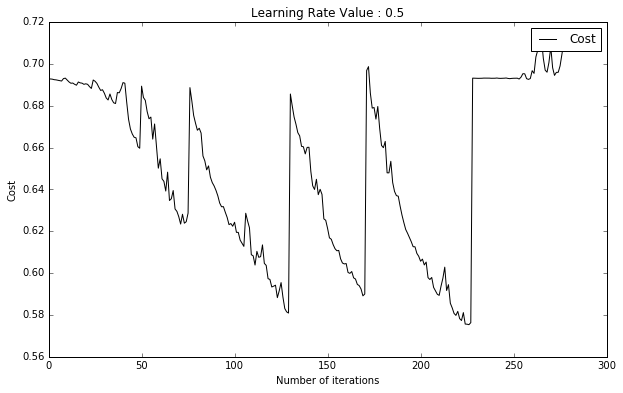

In [118]:
class myThread (threading.Thread):
    def __init__(self, threadID, name, counter, l):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.counter = counter
        self.l = l
        self._return = None
    
    def run(self):
        print ("Starting " + self.name)
        self._return = parallel_batch_sgd(self.name, X, y, self.l)
        print ("Exiting " + self.name)
    

def plotGraph(xvals, yvals, l):
    plt.figure(figsize=(10,6))
    plt.plot(xvals, yvals, color= 'black', label='Cost')
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost')
    plt.legend()
    title = 'Learning Rate Value : ' + str(l)
    plt.title(title)

def test_threads():
    global theta
    global finalJ
    global J
    
    lr_values = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]
    for l in lr_values:
        initial_theta = np.zeros(X.shape[1])
        theta = initial_theta
        theta = theta.reshape(-1,1)
    
#         start_time = datetime.datetime.now()
#         parallel_batch_sgd("No-thread", X, y, l, 400)
#         end_time = datetime.datetime.now()
#         time_diff = end_time - start_time
#         print ("Total time taken with normal batch sgd ", time_diff, "with LR ", l)
        start_time = datetime.datetime.now()
        thread1 = myThread(1, "Thread-1", 1, l)
        thread2 = myThread(2, "Thread-2", 2, l)
        thread3 = myThread(3, "Thread-3", 3, l)
        thread1.start()
        thread2.start()
        thread3.start()
        thread1.join()
        thread2.join()
        thread3.join()
        
        num_iter = list(range(len(finalJ)))
        cost_iter = finalJ
        print (len(num_iter), len(cost_iter))
        plotGraph(num_iter, cost_iter, l)
        
        end_time = datetime.datetime.now()
        time_diff = end_time - start_time
        print ("Total time taken with 3 parallel threads ", time_diff, "with LR ", l)


    
test_threads()

In [119]:
# We see that the number of iterations for convergence have increased from an average of (160) to about ~350 when
# the data is not standardized. The graph plots do not show a steady convergence.